# GEOG788P Term Project
__"Food flows between counties in the United States": Visualization and Analysis__ 

__Brian Slobotsky__

My project is based on a paper published this year in Environmental Research Letters by Lin et al entitled [“Food flows between counties in the United States.”](https://iopscience.iop.org/article/10.1088/1748-9326/ab29ae) The paper used national and subnational data sources to create a model which spatially downscaled commodity flow data to the county scale. 

The project is divided into two sections, the first exploring the data with spatial analysis and the second creating interactive visualizations. I created a custom contiguity matrix using flow linkages as contiguity and tested for both global and local spatial autocorrelation. Lastly, I compared the results to a kernel built contiguity matrix. 

In addition, I visualized flow linkages with the `plotly` module. I also created a function to interactively investigate county relationships with a `folium` choropleth map, including detailed statistics upon hovering. The function utilizes a Python GUI (via `tkinter`) to allow a user to limit the visualization to a single county, a single commodity category, or switch the flow direction.

Please refer to the comments throughout my code in order to follow my step by step process.

## Data pre-processing

The data in this project comes from three main sources. The first is the paper mentioned above. The second is a table of FIPS codes (5 digit unique values for county-level identification) from the US Census Bureau, which is used to convert FIPS codes in the other two data sources to the names of counties or county equivalents. The third is a shapefile of US counties, read into a geodataframe.

In [2]:
import pandas as pd
import geopandas as gp
import numpy as np
import cenpy
import matplotlib.pyplot as plt
from tkinter import *
import folium
from folium.plugins import Search
import plotly.graph_objects as go
from plotly import offline
from math import log10
import webbrowser
import os
from pysal.lib.weights import weights
from pysal.viz.splot.libpysal import plot_spatial_weights
import pysal.explore.esda as esda
import pysal.viz.splot.esda as splot
from libpysal.weights import Kernel
from matplotlib import cm

In [3]:
## loading data ##
# paper data
f = 'erl_14_8_084011_sd_3.csv'
db = pd.read_csv(f)

## setting up dictionary between stcg category names and data column abbreviations
sctg_dict = {'Live Animals and Fish':'sctg_1', 
             'Cereal Grains (including seed)':'sctg_2',
             'Agricultural Products except Animal Feed, Cereal Grains, and Forage Products':'sctg_3',
             'Animal Feed, Eggs, Honey, and Other Products of Animal Origin':'sctg_4',
             'Meat, Poultry, Fish, Seafood, and Their Preparations':'sctg_5',
             'Milled Grain Products and Preparations, and Bakery Products':'sctg_6',
             'Other Prepared Foodstuffs, Fats and Oils':'sctg_7',
             'Total':'total'}
## variable with category names
ckeys = list(sctg_dict.keys())

## changing fips codes into five digits
a = []
for i in db['ori']:
    i = str(i)
    i = i.zfill(5)
    a.append(i)
db['ori'] = a

b = []
for i in db['des']:
    i = str(i)
    i = i.zfill(5)
    b.append(i)
db['des'] = b
dbi = db.copy()             ## making a copy for later

# census data 
fips = cenpy.explorer.fips_table("county")

## creating a fips code column
fips[5] = ""
fips[6] = ""

a = [] 
for i in fips[1]:
    i = str(i)
    i = i.zfill(2)
    a.append(i)
fips[5] = a

b = []
for i in fips[2]:
    i = str(i)
    i = i.zfill(3)
    b.append(i)
fips[6] = b

fips[7] = fips[5] + fips[6]

## tidying data
fips.columns = ['state','col2','col3','name','col5','FIPS_state','FIPS_county','FIPS']
fips.drop(['col2','col3','col5'],axis=1, inplace = True)
fips = fips[fips.FIPS_state < '57']

fips['fullname'] = fips['name'] + ", " + fips['state']

## creating a dictionary with county names and FIPS codes
fipsdict = dict(zip(fips['fullname'],fips['FIPS']))
## assigning county names to a variable
dkeys = list(fipsdict.keys())

# geographic data
gdf = gp.read_file("tl_2019_us_county.shp")
gdf['FIPS'] = gdf['GEOID']
gdf.drop(gdf.columns[:17],axis=1, inplace = True)

## Exploratory Spatial Data Analysis

To begin, I explored the paper's model by constructing contiguity matrices based on flow linkages, one for each flow direction.  These custom matrices represent destinations of a single origin county and origins of a single destination county. These matrices are spatial-based but not adjacency-based, and will be compared to kernel-based spatial adjacency matrices when discussing spatial autocorrelation.

In [4]:
# creating custom contiguity matrices for origins and destinations

## creating a list of unique counties and setting empty dictionaries 
uni = gdf.FIPS.unique()
sums = gdf.copy()    ## for later use
neighO = {}          ## essentially {'county':'destination1','destination2',etc...}
weightO = {}
## for each unique origin county, finding its destination counties and total values
for i in range(len(uni)):
    try: 
        ## if the county is an origin county, this code will run 
        orilim = dbi[dbi.ori == uni[i]]
        ## converting columns to lists
        des = orilim.des.tolist()
        tot = orilim.total.tolist()
    except:
        ## if the county is only a destination county, this code will run
        des = [0]
        tot = [0]
    finally:
        ## adding lists as dictionary values
        neighO[uni[i]] = des
        weightO[uni[i]] = tot
## using the two dictionaries to construct a weights matrix
oW = weights.W(neighO, weightO)

## repeating the process for destination
neighD = {}      ## essentially {'county':'origin1','origin2',etc...}
weightD = {}
## for each unique origin county, finding its origin counties and total values
for i in range(len(uni)):
    try: 
        ## if the county is an destination county, this code will run 
        deslim = dbi[dbi.des == uni[i]]
        ## converting columns to lists
        ori = deslim.ori.tolist()
        tot = deslim.total.tolist()
    except:
        ## if the county is only an origin county, this code will run
        ori = [0]
        tot = [0]
    finally:
        ## adding lists as dictionary values
        neighD[uni[i]] = ori
        weightD[uni[i]] = tot
## using the two dictionaries to construct a weights matrix
dW = weights.W(neighD, weightD)

C:\Users\Brian\Anaconda\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning:

There are 30 disconnected observations 
  Island ids: 02013, 02050, 02070, 02105, 02150, 02158, 02164, 02170, 02180, 02188, 02195, 02198, 02220, 02230, 02240, 02261, 02275, 02290, 13025, 13319, 21203, 26039, 26095, 48105, 48267, 48443, 54007, 54093, 54101, 54109

C:\Users\Brian\Anaconda\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning:

There are 14 disconnected observations 
  Island ids: 02013, 02060, 02105, 02158, 02195, 02198, 02230, 02275, 26095, 29203, 30071, 48443, 54021, 54101



Now I explored the cardinalities of each matrix. Here are histrograms for both matrices.

(51.36664544875875, 57.70553874894481)

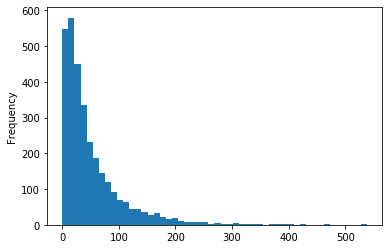

In [7]:
pd.Series(oW.cardinalities).plot.hist(bins=50)
pd.Series(oW.cardinalities).mean(), pd.Series(oW.cardinalities).std()

(51.36664544875875, 59.402982270189895)

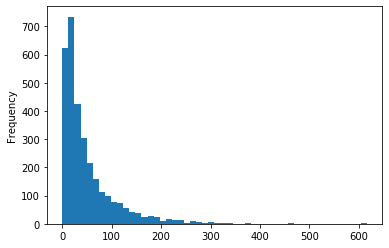

In [8]:
pd.Series(dW.cardinalities).plot.hist(bins=50)
pd.Series(dW.cardinalities).mean(), pd.Series(dW.cardinalities).std()

As you can see, both matrices have very similar cardinality distribution. Some counties have hundreds of origins or destinations in the model, while most have only dozens of origins or destinations. The average origin and destination cardinality in the model is about 51.4, with the standard deviation of about 57.7 in the origin contiguity matrix and approximately 59.4 in the destination matrix.

Next, I mapped the cardinalities.

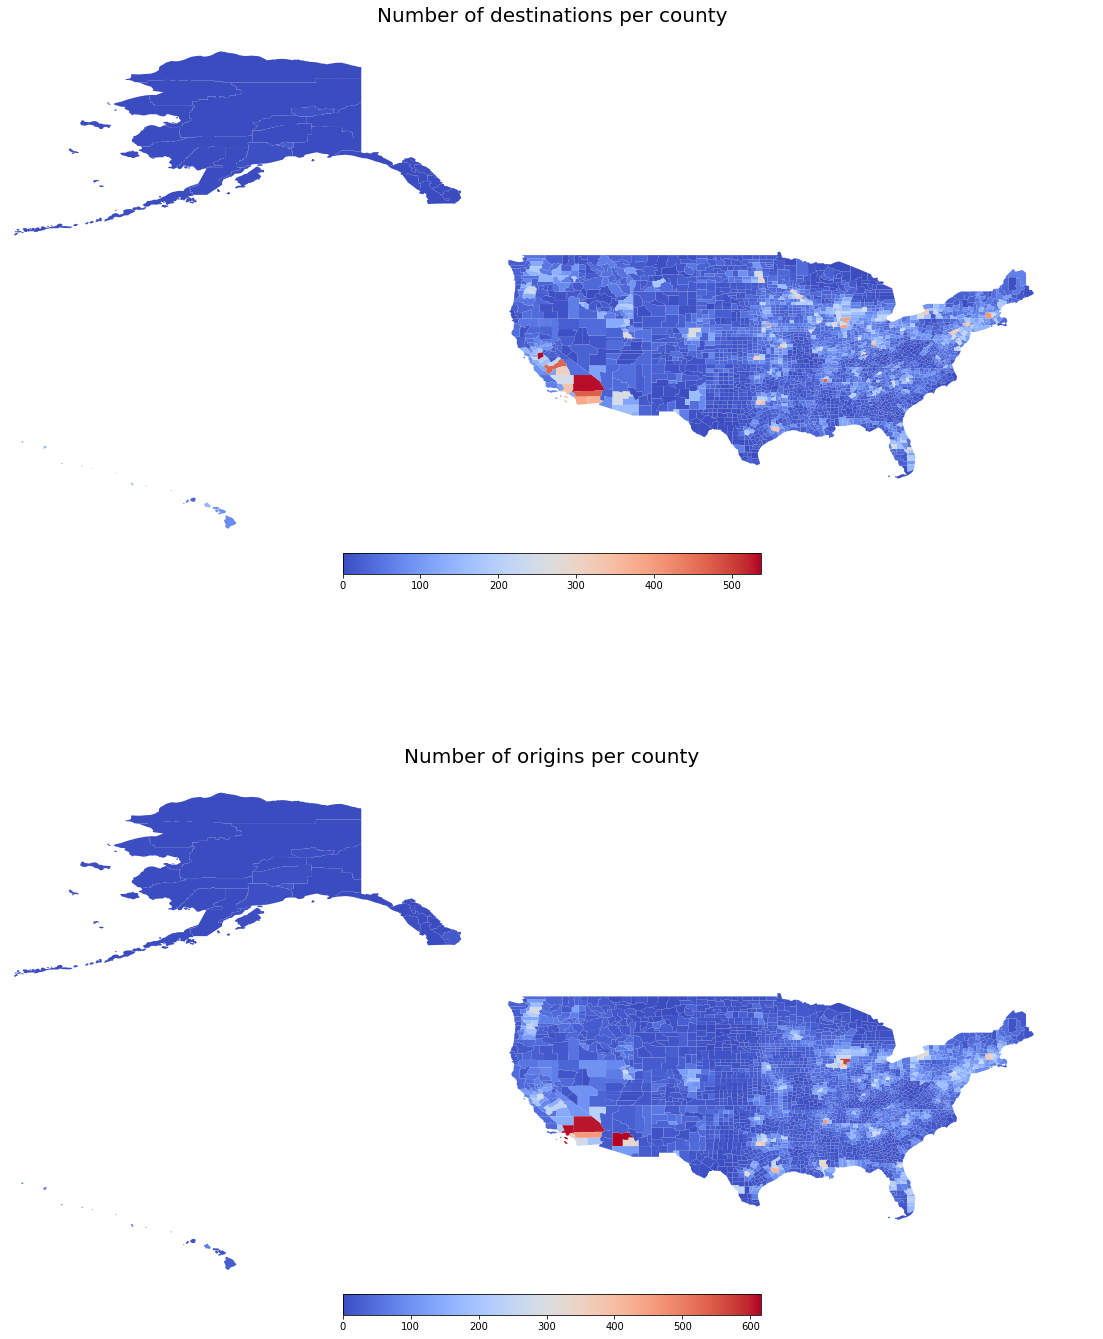

In [9]:
# mapping cardinalities
## constructing a dataframe from the cardinality dictionary
o_card_df = pd.DataFrame.from_dict(oW.cardinalities, orient='index', columns=['o_n'])
o_card_df['FIPS'] = o_card_df.index
## merging dataframe to the counties geodataframe
o_card = sums.merge(o_card_df, how = 'left', on='FIPS')
o_card = o_card.fillna(0)

## repeating for the second set of cardinalities
d_card_df = pd.DataFrame.from_dict(dW.cardinalities, orient='index', columns=['d_n'])
d_card_df['FIPS'] = d_card_df.index
d_card = sums.merge(d_card_df, how = 'left', on='FIPS')
d_card = d_card.fillna(0)

## plotting both maps
fig, axes = plt.subplots(2,1, figsize=(50, 25))
o_card.plot(column='o_n',cmap='coolwarm',ax=axes[0])
d_card.plot(column='d_n',cmap='coolwarm',ax=axes[1])
## axes, titles, and colorbars
axes[0].axis('off')
axes[0].set_xlim([-180,-60])
axes[0].set_title('Number of destinations per county',fontdict={'fontsize':'20'})
plt.colorbar(cm.ScalarMappable(cmap= 'coolwarm', norm = plt.Normalize(vmin = 0, vmax = o_card.o_n.max())),
             ax=axes[0],shrink = 0.15,orientation = 'horizontal',pad=0)
axes[1].axis('off')
axes[1].set_xlim([-180,-60])
axes[1].set_title('Number of origins per county',fontdict={'fontsize':'20'})
plt.colorbar(cm.ScalarMappable(cmap= 'coolwarm', norm = plt.Normalize(vmin = 0, vmax = d_card.d_n.max())), 
             ax=axes[1],shrink = 0.15,orientation = 'horizontal',pad=0)   

As we can see, the maps look very similar. Overall, counties in California and the Midwest have higher numbers of destination counties. Populated areas, such as Los Angeles County CA, Maricopa County AZ, and Cook County IL, have higher numbers of origin counties. 

In this next section, I will investigate global and local spatial autocorrelation of the total flow value variable. Four models will be tested, single origin or single destination flow directions combined with kernel contiguity or flow-based contiguity. Single origin flow direction is defined as the matrix where a single origin county has contiguity with its destination counties. A kernel value of 51 is used, since that is closest to the average cardinality of the flow matrices. 

A Moran's I test with the kernel-based matrix will test for spatial autocorrelation, while the Moran's I test for the flow-based matrix will test "pseudo-spatial" autocorrelation, meaning the flow matrix is based on flow relationships and not adjacency. The Moran's I values for the flow matrix should be interpreted as autocorrelation between a county and its origins or destinations and not as a county and its geographic neighbors.

In [13]:
# Moran's I Test for global spatial autocorrelation
## preparing the data by grouping by origin county
ori_df = dbi.groupby(['ori']).sum()
ori_df['FIPS'] = ori_df.index
## joining the dataframe to the counties geodataframe
ori_gdf = sums.merge(ori_df, how = 'left', on='FIPS')
ori_gdf = ori_gdf.fillna(0)
## repeating the steps but grouping by destination county
des_df = dbi.groupby(['des']).sum()
des_df['FIPS'] = des_df.index
des_gdf = sums.merge(des_df, how = 'left', on='FIPS')
des_gdf = des_gdf.fillna(0)

## creating spatial weights from kernel of 51
kernel_oW = Kernel.from_dataframe(ori_gdf, k=51, fixed=False, function='gaussian')
kernel_dW = Kernel.from_dataframe(des_gdf, k=51, fixed=False, function='gaussian')

## performing global Moran's I for the four models (combinations of two flow directions and two matrix conceptualizations)
kso_mi = esda.moran.Moran(ori_gdf['total'], kernel_oW)
ksd_mi = esda.moran.Moran(des_gdf['total'], kernel_dW)  
fbo_mi = esda.moran.Moran(ori_gdf['total'], oW)
fbd_mi = esda.moran.Moran(des_gdf['total'], dW)
## printing the results
print("Moran's I for kernel contiguity model:\nSingle origin I value: {0}\tp-value: {1}\nSingle destination I value: {2}\tp-value: {3}".format(kso_mi.I,kso_mi.p_sim,ksd_mi.I,ksd_mi.p_sim))
print("\nMoran's I for flow-based contiguity model:\nSingle origin I value: {0}\tp-value: {1}\nSingle destination I value: {2}\tp-value: {3}".format(fbo_mi.I,fbo_mi.p_sim,fbd_mi.I,fbd_mi.p_sim))

Moran's I for kernel contiguity model:
Single origin I value: 0.37593643935159154	p-value: 0.001
Single destination I value: 0.3184896472866035	p-value: 0.001

Moran's I for flow-based contiguity model:
Single origin I value: 0.0995876761791736	p-value: 0.244
Single destination I value: 0.06914841408133425	p-value: 0.352


We can see from the large p-values that the flow-based conceptualization of contiguity does not have statistically significant spatial autocorrelation. However, the kernel-based model shows statistically significant positive spatial autocorrelation in both flow directions, meaning that similar total flow values cluster together across the United States, regardless of flow direction. 

I then tested and mapped local spatial autocorrelation:

C:\Users\Brian\Anaconda\lib\site-packages\ipykernel_launcher.py:18: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



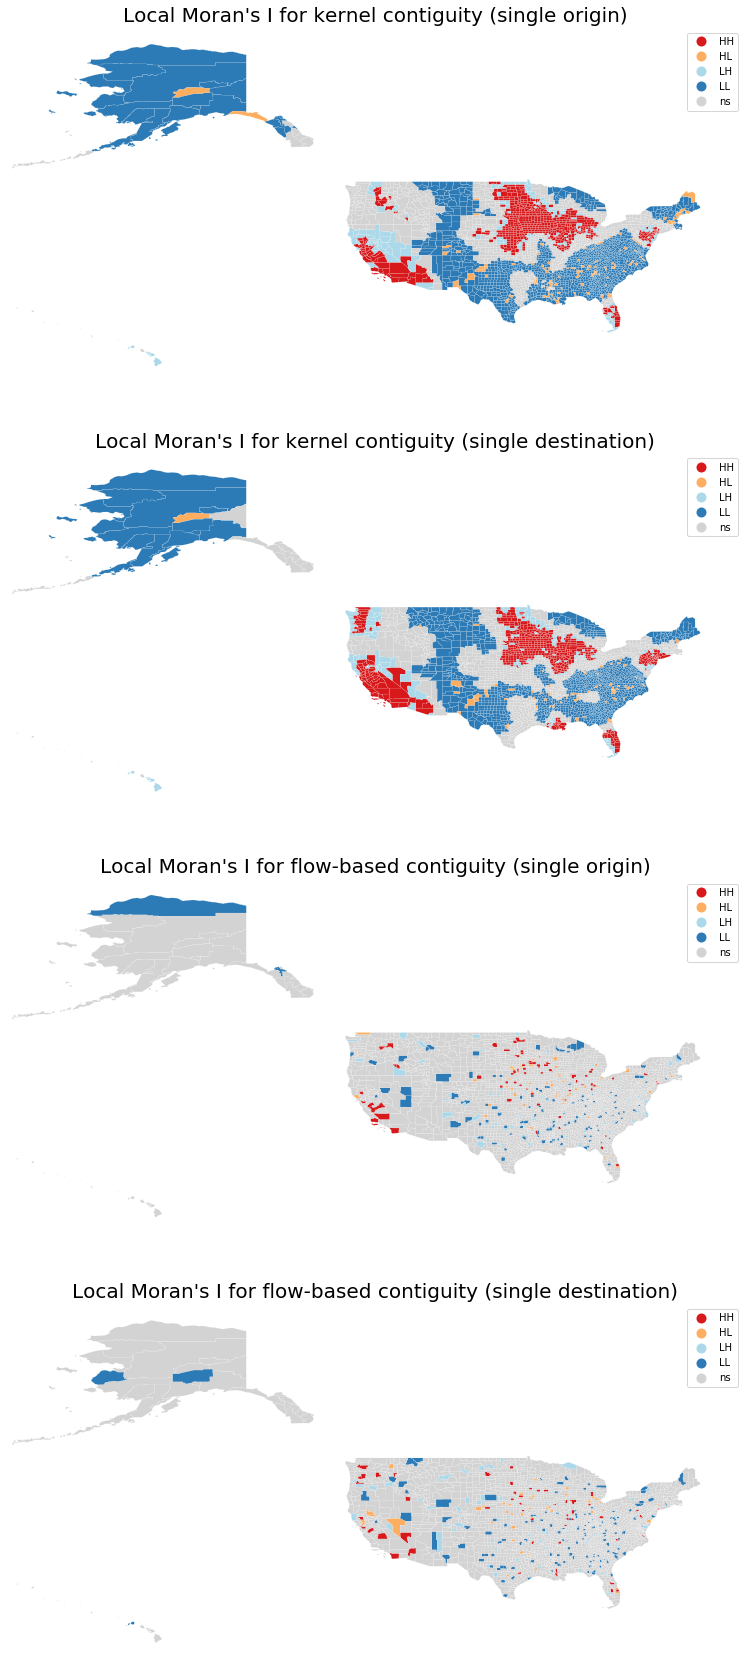

In [14]:
# measuring local spatial autocorrelation for each of the four models
kso_lisa = esda.moran.Moran_Local(ori_gdf['total'], kernel_oW)
ksd_lisa = esda.moran.Moran_Local(des_gdf['total'], kernel_dW)  
fbo_lisa = esda.moran.Moran_Local(ori_gdf['total'], oW)
fbd_lisa = esda.moran.Moran_Local(des_gdf['total'], dW)

# plotting LISA maps
fig, ax = plt.subplots(4,1, figsize=(50,30))
splot.lisa_cluster(kso_lisa, ori_gdf, ax=ax[0])
ax[0].set_title("Local Moran's I for kernel contiguity (single origin)",fontdict={'fontsize':'20'})
splot.lisa_cluster(ksd_lisa, des_gdf, ax=ax[1])
ax[1].set_title("Local Moran's I for kernel contiguity (single destination)",fontdict={'fontsize':'20'})
splot.lisa_cluster(fbo_lisa, ori_gdf, ax=ax[2])
ax[2].set_title("Local Moran's I for flow-based contiguity (single origin)",fontdict={'fontsize':'20'})
splot.lisa_cluster(fbd_lisa, des_gdf, ax=ax[3])
ax[3].set_title("Local Moran's I for flow-based contiguity (single destination)",fontdict={'fontsize':'20'})
for i in range(4): ax[i].set_xlim([-180,-60])      ## limiting the view to the US
fig.show()

There are huge clusters of similar values in the kernel models, and the two flow direction maps are noticeably quite similar. 

The flow-based maps appear to show "dispersed clusters" since contiguity is not spatially defined. This allows for a clearer view of high and low value clusters and outliers in the original paper's flow model, and displays trends similar to the cardinality maps seen previously. Midwestern and California counties contain clusters of high values in the origin model, and populated areas such as San Diego, Las Vegas, Seattle, Chicago, and Kansas City are all in high value clusters in the destination model.

## Plotly Map

Mapping all flow lines was a burden on my laptop's processor due to the large amount of data, with over 160,000 lines to draw. I used `plotly` to map the top 10,000 flows measured by total value, pictured below as a static map. Flow lines vary in opacity and width by the total value of the flow. Below the picture is the code to replicate an interactive version of this map as a HTML file in a new tab of your browser.

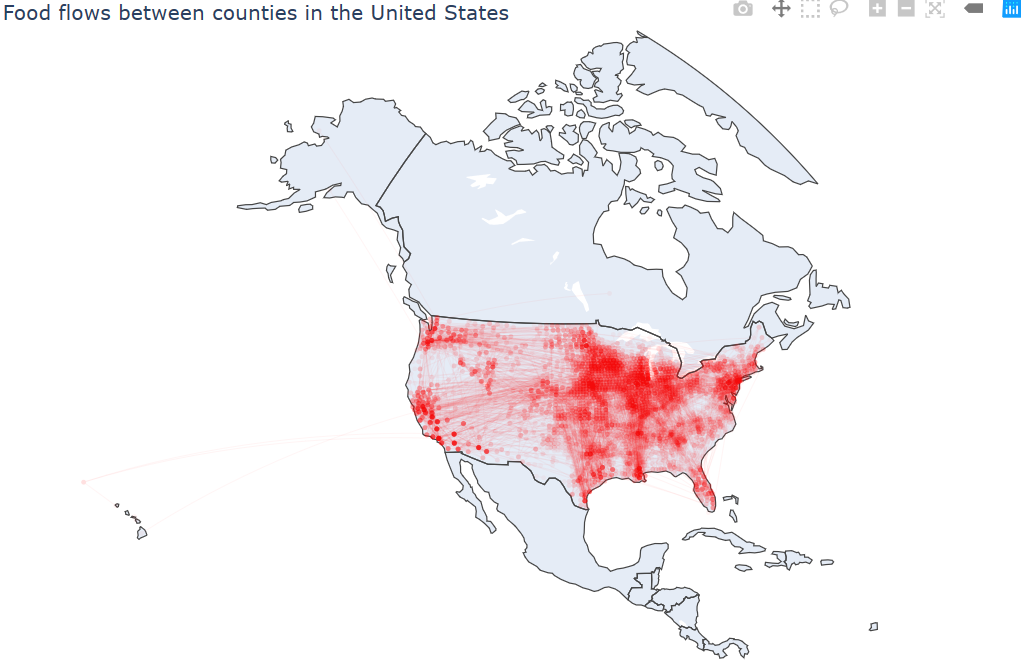

In [4]:
# preparing data for main flow map
## getting coordinates from centroids for each county
countypoints = gdf.copy()
countypoints['x'] = countypoints['geometry'].centroid.x
countypoints['y'] = countypoints['geometry'].centroid.y
countypoints.drop(['geometry'],axis=1, inplace = True)
## merging coordinates to paper data by FIPS code
### for origin county
db = db[db.ori != db.des]                    ## removing intra-county flows to improve performance
merged = db.merge(countypoints, how = 'left', left_on='ori', right_on='FIPS')
merged['olong'], merged['olat'] = merged['x'], merged['y']
merged.drop(['FIPS','x','y'],axis=1, inplace = True)
### for destination county
latlong_db = merged.merge(countypoints, how = 'left', left_on='des', right_on='FIPS')
latlong_db['dlong'], latlong_db['dlat'] = latlong_db['x'], latlong_db['y']
latlong_db.drop(['FIPS','x','y'],axis=1, inplace = True)
### limiting data to the 10,000 county flows with highest volume (due to processing limitations) 
latlong_db = latlong_db.sort_values(by='total',ascending=False)   ## sorting by 'total', highest to lowest
latlong_db = latlong_db[:10000]                                   ## keeping only the first 10,000 records

# using plotly for main flow map
fig = go.Figure()
## creating lines with a for loop
for i in range(10000):
    fig.add_trace(
        go.Scattergeo(
            ## using lines and markers
            mode = 'lines+markers',
            lon = [latlong_db.iloc[i, 10], latlong_db.iloc[i, 12]],
            lat = [latlong_db.iloc[i, 11], latlong_db.iloc[i, 13]],
            ## line width, marker size, and opacity based on 'total' column
            line = dict(width = log10(float(latlong_db.iloc[i, 7])) / log10(float(latlong_db['total'].max()))
                        ,color = 'red'),
            marker = dict(size = 5 * (log10(float(latlong_db.iloc[i, 7])) / log10(float(latlong_db['total'].max())))),
            opacity = 0.05 * (log10(float(latlong_db.iloc[i, 7])) / log10(float(latlong_db['total'].max()))),
            ## no legend or hovering
            showlegend = False,
            hoverinfo = 'skip'
        )
    )
## custom layout
fig.update_layout(
    autosize = False,
    width = 900,
    height = 600,
    margin = go.layout.Margin(l=0, r=0, b=0, t=0, pad=0),
    title_text = '<br>Food flows between counties in the United States',
    ## setting view and projection
    geo = go.layout.Geo(scope = 'north america', projection_type = 'azimuthal equidistant')
)
## displaying the map
offline.plot(fig, filename='plotly_project.html')

'plotly_project.html'

## Interactive Folium Map

I used `folium` to create a user-customized Leaflet visualization of the flow data, with a user interface window from `tkinter`. The following code contains some necessary data pre-processing.

In [7]:
# setting up the statistics which appear when hovering

## finding top origin county and associated value
### creating an empty data frame
o_stats = pd.DataFrame()
### appending to the data frame by iterating through unique FIPS codes
for i in range(len(uni)): 
    try: 
        ### if the county is a destination county, limiting the df to only this county 
        deslim = dbi[dbi.des == uni[i]]
        ### sorting with highest value as first row
        deslim = deslim.sort_values(by='total',ascending=False)
        ### assigning the first row FIPS and value to variables
        ori = deslim.ori.iloc[0]
        tot = round(float(deslim.total.iloc[0]),2)
    except:
        ### if the county is only an origin county, this code will run
        ori = uni[i]
        tot = [0]
    finally:
        ### finally, appending to the data frame with the destination and origin FIPS and origin value 
        o_stats = o_stats.append({'FIPS': uni[i],'top_ori': ori,'top_otot': tot}, ignore_index=True)

## creating a name column using the FIPS dictionary
names = []
for i in o_stats['top_ori']:
    ### using FIPS values to find keys (names)
    try: a = dkeys[list(fipsdict.values()).index(i)]
    except: a = 'NaN'
    finally: names.append(a)
o_stats['top_o_name'] = names    

## repeating the code for the opposite direction
d_stats = pd.DataFrame()
for i in range(len(uni)): 
    try: 
        ## if the county is an origin county, limiting the df to only this county 
        orilim = dbi[dbi.ori == uni[i]]
        orilim = orilim.sort_values(by='total',ascending=False)
        des = orilim.des.iloc[0]
        tot = round(float(orilim.total.iloc[0]),2)
    except:
        ## if the county is only a destination county, this code will run
        des = uni[i]
        tot = [0]
    finally:
        d_stats = d_stats.append({'FIPS': uni[i],'top_des': des,'top_dtot': tot}, ignore_index=True)

## name column
names = []
for i in d_stats['top_des']:
    try: a = dkeys[list(fipsdict.values()).index(i)]
    except: a = 'NaN'
    finally: names.append(a)
d_stats['top_d_name'] = names    

## merging origin and destination dataframes
hoverstats = o_stats.merge(d_stats, how = 'left', on='FIPS')
## creating columns for number of origin counties and number of destination counties
num_ori = []
num_des = []
### using dictionaries from the custom contiguity matrices to get a count per county
for i in o_stats['FIPS']:
    a = len(neighD[i])
    b = len(neighO[i])
    num_ori.append(a)
    num_des.append(b)
hoverstats['num_ori'] = num_ori
hoverstats['num_des'] = num_des

The code below will launch a pop-up window where you can refine the map to a single county, a single commodity category, or reverse the flow direction visualization between origin and destination. The output will open in a new tab in your browser as a HTML file. On the map, you can search for a county, turn layers off, and hover over a county to read statistics about that county.

In [10]:
## USER INTERFACE VIA TKINTER ##

# setting the window design
root = Tk()
mainframe = Frame(root)
mainframe.grid(column=0,row=0,sticky=(N,W,E,S))
mainframe.columnconfigure(0, weight = 1)
mainframe.rowconfigure(0, weight = 1)
mainframe.pack(pady = 100, padx = 100)

# three user inputs
## first, choosing a county
### setting the variable
tkvar_geo = StringVar(root)
tkvar_geo.set('')                ## no default value
choices_geo = dkeys              ## list of items are the keys from the fips dictionary

### formatting 
popupMenu_geo = OptionMenu(mainframe, tkvar_geo, *choices_geo)
popupMenu_geo.grid(row = 0, column = 1, sticky = W)
Label(mainframe, text="Select a county:").grid(row = 0, column = 0, sticky = W)

## second, switching between "origin" and "destination"
### setting the variable
tkvar_dir = StringVar(root)
tkvar_dir.set('Origin')             ## setting origin as default
choices_dir = ['Origin', 'Destination']
## dictionary needed for legend display later 
opposite = {'Origin':'destinations', 'Destination':'origins'}

### formatting
popupMenu_dir = OptionMenu(mainframe, tkvar_dir, *choices_dir)
popupMenu_dir.grid(row = 2, column = 1, sticky = W)
Label(mainframe, text="Change flow direction:").grid(row = 2, column = 0, sticky = W)

## third, selecting a SCTG category
### setting the variable
tkvar_com = StringVar(root)
choices_com = ckeys                 ## list of items are the keys from the sctg dictionary
tkvar_com.set('Total')              ## setting total as default

### formatting
popupMenu_com = OptionMenu(mainframe, tkvar_com, *choices_com)
popupMenu_com.grid(row = 4, column = 1, sticky = W)
Label(mainframe, text="Select a commodity category:").grid(row = 4, column = 0, sticky = W)

# adding window title and exit button
root.title('Input Window')
exitButton = Button(root, text = 'Done', command = root.destroy)
exitButton.pack(side = 'bottom')
root.mainloop()

# assigning user inputs to variables
geo_input = tkvar_geo.get()
dir_input = tkvar_dir.get()
com_input = tkvar_com.get()

## CREATING A GEOJSON WITH USER INPUTS ##

## defining "geo_val" as the FIPS equivalent of a user inputted county name
geo_val = fipsdict.get(geo_input)
## defining "com_val" as the sctg column equivalent of a user inputted sctg category
com_val = sctg_dict.get(com_input)
## using the user inputted direction
if dir_input == 'Origin':
    ## grouping by destination (destination counties for one origin county)
    limval = db[db.ori == geo_val]
    limval = limval.groupby(['des'])[com_val].sum()
else:
    ## grouping by origin (origin counties for one destination county)
    limval = db[db.des == geo_val]
    limval = limval.groupby(['ori'])[com_val].sum()  
## converting back to dataframe
dfval = pd.DataFrame({'FIPS':limval.index, com_val:limval.values})
## join total value to gdf by the FIPS column
gdf_new = gdf.merge(dfval, how = 'left', on='FIPS')
## creating a name column using the fips dictionary to be used in the hovering functionality
a = []
for i in gdf_new['FIPS']:
    ## avoiding an indexing error by using try and except statements
    try: i = dkeys[list(fipsdict.values()).index(i)]
    except: i = 'NaN'
    finally: a.append(i)
gdf_new['name'] = a
## replacing NaN with 0
gdf_new[com_val] = gdf_new[com_val].replace(np.nan, 0)
gdf_new['val'] =  gdf_new[com_val]
gdf_new['val'] = gdf_new['val'].round(2)
## merging statistics in, to be displayed when hovering 
new = gdf_new.merge(hoverstats, how = 'left', on='FIPS')
new = new.replace(np.nan, 0)         ## just in case
## deleting counties with 0 values to create a manageable geojson size
new = new.loc[new.val > 0, ['FIPS','geometry','name','val','top_otot','top_o_name','top_dtot','top_d_name','num_ori','num_des']] 
## avoiding error if dataframe is empty (invalid choice combination)
if new.empty == True:
    ## altering user of error
    print('Input combination does not exist. Please try another combination')
else:
    ## gdf to geojson
    new.to_file("output.geojson", driver="GeoJSON")
    ## message to user showing the final selection
    print('You are viewing {0} flows with {1} as the {2} county'.format(com_input, geo_input, dir_input.lower()))
    
    ## FOLIUM CHOROPLETH MAPPING ##
    ### basemap
    m = folium.Map(location=[39.8, -98.5],tiles='cartodbpositron', prefer_canvas = True, zoom_start = 3)
    ### choropleth
    choro = folium.Choropleth(geo_data="output.geojson",
                              data = new,
                              name = 'Choropleth',
                              columns = ['FIPS','val'],
                              key_on='properties.FIPS',
                              fill_color='YlGn', fill_opacity=0.5, line_opacity=0.5,
                              legend_name = com_input + " flow " + opposite.get(dir_input) + ", measured in kilograms"
                             ).add_to(m)
    ### hover functionality
    choro.geojson.add_child(folium.features.GeoJsonTooltip(
        fields=['name','val','num_ori','top_o_name','top_otot','num_des','top_d_name','top_dtot'],
        aliases=['County name:','Value (kg):','Number of Origin Counties:','Largest Origin County:','Largest Origin Value (kg):',
                 'Number of Destination Counties:','Largest Destination County:','Largest Destination Value (kg):']
    ))
    ### red outline for the selected county 
    polygon = gdf.loc[gdf.FIPS == fipsdict.get(geo_input), ['geometry']]
    folium.GeoJson(polygon, tooltip=geo_input, name=geo_input, 
                   style_function=lambda x: {'color':'#ff0000','fillColor': 'none'}
                  ).add_to(m)
    ### adding search functionality
    Search(layer = choro, geom_type = 'Polygon', search_label = 'name').add_to(m)
    ### allowing layers to be turned off
    folium.LayerControl().add_to(m)
    ### saving to an html and opening in web browser
    m.save('folium_project.html')
    webbrowser.open('file://' + os.path.realpath('folium_project.html'))

Input combination does not exist. Please try another combination


To make a new selection, you will need to re-launch the user interface by running the block of code again.  